In [2]:
import numpy as np, pandas as pd
import sqlite3 as sql
import os
import seaborn as sns
import plotly.graph_objs as go
from dotenv import load_dotenv
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import db_info, db_table_samples, select_statement_to_df, get_from_table

In [3]:
load_dotenv()

True

In [4]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 99)

In [20]:
days_since_last_lb_update_df = select_statement_to_df("""

WITH DAYS_SINCE_LAST_STREAMING_UPDATE AS (

SELECT FILM_ID, ROUND(AVG(DAYS_SINCE_LAST_UPDATE), 0) AS DAYS_SINCE_LAST_UPDATE 
FROM ( SELECT FILM_ID, ROUND(COALESCE(julianday('now') - julianday(CREATED_AT), 99), 0) AS DAYS_SINCE_LAST_UPDATE FROM FILM_STREAMING_SERVICES )
GROUP BY FILM_ID

)

SELECT a.FILM_ID
FROM FILM_ALGO_SCORE a
LEFT JOIN DAYS_SINCE_LAST_STREAMING_UPDATE b
ON a.FILM_ID = b.FILM_ID
ORDER BY COALESCE(a.ALGO_SCORE,0.01) * COALESCE(b.DAYS_SINCE_LAST_UPDATE, 365) DESC

""")

# days_since_last_lb_update_df['DAYS_SINCE_LAST_UPDATE'] = days_since_last_lb_update_df['DAYS_SINCE_LAST_UPDATE'] + 0.02

days_since_last_lb_update_df

,FILM_ID
0,f_01Oeo
1,f_0azpu
2,f_01rZw
3,f_062Te
4,f_05jfy
...,...
17428,f_0zu4c
17429,f_0fx08
17430,f_0Aiyc
17431,f_0BQFe


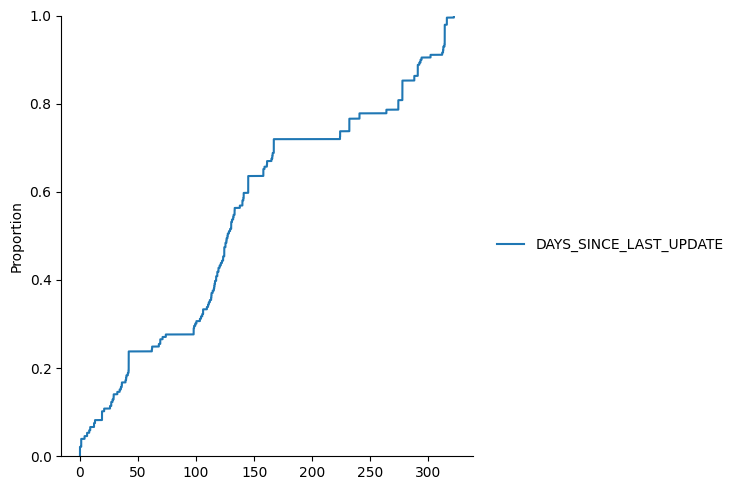

In [ ]:
sns.displot(days_since_last_lb_update_df, kind='ecdf')

In [9]:
diary_df = select_statement_to_df('SELECT * FROM DIARY')
diary_df

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH,IS_NARRATIVE_FEATURE
0,f_01ZLI,2021-01-01,2.5,,1,1
1,f_01UTC,2021-01-01,4.0,,1,1
2,f_020E4,2021-01-02,3.0,physicalmedia,1,1
3,f_01TBi,2021-01-02,4.0,physicalmedia,1,1
4,f_03z48,2021-01-02,4.0,bbciplayer,1,0
...,...,...,...,...,...,...
1311,f_01I0g,2024-02-18,4.0,internet,1,1
1312,f_0ceXk,2024-02-19,4.0,4od,1,0
1313,f_02Evm,2024-02-20,2.5,5od,1,1
1314,f_02bcA,2024-02-20,5.0,cinema,0,1


In [10]:
diary_df.insert(2, 'WATCH_ORDER_DAY', diary_df.groupby(['WATCH_DATE']).cumcount() + 1)
diary_df

,FILM_ID,WATCH_DATE,WATCH_ORDER_DAY,FILM_RATING,TAGS,FIRST_TIME_WATCH,IS_NARRATIVE_FEATURE
0,f_01ZLI,2021-01-01,1,2.5,,1,1
1,f_01UTC,2021-01-01,2,4.0,,1,1
2,f_020E4,2021-01-02,1,3.0,physicalmedia,1,1
3,f_01TBi,2021-01-02,2,4.0,physicalmedia,1,1
4,f_03z48,2021-01-02,3,4.0,bbciplayer,1,0
...,...,...,...,...,...,...,...
1311,f_01I0g,2024-02-18,1,4.0,internet,1,1
1312,f_0ceXk,2024-02-19,1,4.0,4od,1,0
1313,f_02Evm,2024-02-20,1,2.5,5od,1,1
1314,f_02bcA,2024-02-20,2,5.0,cinema,0,1


In [4]:
all_features_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
, DIRECTOR_TABLE AS (

  SELECT FILM_ID, GROUP_CONCAT(DIRECTOR_NAME, ', ') AS DIRECTOR_NAME FROM ( 

    SELECT
      
      a.FILM_ID
      ,c.PERSON_NAME AS DIRECTOR_NAME

    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN PERSON_INFO c
    ON b.PERSON_ID = c.PERSON_ID

    WHERE b.job = 'Director'
    AND c.PERSON_NAME IS NOT NULL

    )

  GROUP BY FILM_ID

)
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,g.FILM_RATING_SCALED
      ,i.FILM_POSITION
      ,c.FILM_WATCH_COUNT
      ,k.TOP_250_POSITION AS FILM_TOP_250
      ,c.FILM_RATING
      ,COALESCE(1.0*c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,COALESCE(1.0*c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,h.DIRECTOR_NAME
      ,d.FILM_RUNTIME
      ,f.FILM_YEAR
      ,e.FILM_GENRE
      ,e.ALL_FILM_GENRES
      ,j.COLLECTION_NAME
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN PERSONAL_RATING g
    ON a.FILM_ID = g.FILM_ID
    LEFT JOIN DIRECTOR_TABLE h
    ON a.FILM_ID = h.FILM_ID
    LEFT JOIN PERSONAL_RANKING i
    ON a.FILM_ID = i.FILM_ID
    LEFT JOIN FILM_COLLECTIONS j
    ON a.FILM_ID = j.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_TOP_250 k
    ON a.FILM_ID = k.FILM_ID

"""

In [5]:
keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    AND a.FILM_ID IS NOT NULL
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND MY_RATING_COUNT >= 3
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE a.FILM_ID IS NOT NULL 
AND b.KEYWORD_ID IS NOT NULL
AND b.KEYWORD_ID > -1

"""

In [6]:
eligible_watchlist_df = select_statement_to_df(all_features_query)
eligible_watchlist_df

,FILM_ID,FILM_TITLE,FILM_RATING_SCALED,FILM_POSITION,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,DIRECTOR_NAME,FILM_RUNTIME,FILM_YEAR,FILM_GENRE,ALL_FILM_GENRES,COLLECTION_NAME
0,f_01ZLI,Jumanji,2.565534,866.0,855465,NaN,3.59,0.180959,0.000964,Joe Johnston,104,1995,fantasy,fantasy/family/adventure,Jumanji Collection
1,f_01UTC,Fatal Attraction,3.842486,287.0,99624,NaN,3.45,0.161015,0.001194,Adrian Lyne,119,1987,drama,drama/thriller,
2,f_020E4,Punch-Drunk Love,3.069742,679.0,478441,NaN,4.00,0.323574,0.016301,Paul Thomas Anderson,96,2002,drama,drama/thriller/comedy/romance,
3,f_01TBi,Altered States,4.099711,198.0,56562,NaN,3.64,0.262597,0.004261,Ken Russell,102,1980,horror,horror/science-fiction/thriller,
4,f_0t4EQ,Death to 2020,NaN,NaN,80643,NaN,2.70,0.112285,0.000037,"Al Campbell, Alice Mathias",71,2020,comedy,comedy,Death to Collection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,f_01HmU,Bedazzled,NaN,NaN,7343,NaN,3.46,0.205638,0.006401,Stanley Donen,103,1967,romance,romance/comedy/fantasy,
15427,f_010um,Myra Breckinridge,NaN,NaN,2653,NaN,2.78,0.180927,0.003769,Michael Sarne,94,1970,drama,drama/comedy,
15428,f_01y1e,Barabbas,NaN,NaN,3026,NaN,3.48,0.163913,0.001983,Richard Fleischer,137,1961,drama,drama/adventure/history,
15429,f_01VQE,Zorba the Greek,NaN,NaN,11758,NaN,3.71,0.219000,0.011482,None,142,1964,drama,drama,


In [7]:
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
eligible_watchlist_df = eligible_watchlist_df.merge(keyword_df_wide, how='left', on='FILM_ID')

In [8]:
eligible_watchlist_df

,FILM_ID,FILM_TITLE,FILM_RATING_SCALED,FILM_POSITION,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,DIRECTOR_NAME,FILM_RUNTIME,FILM_YEAR,FILM_GENRE,ALL_FILM_GENRES,COLLECTION_NAME,18th century,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,19th century,action hero,addiction,adoption,adultery,adventurer,africa,aftercreditsstinger,afterlife,agent,airplane,airport,alcohol,alcoholic,alien,alien invasion,alien life-form,amnesia,amusement park,anarchic comedy,android,animal attack,animal horror,anime,...,thanksgiving,theft,thief,time loop,time travel,torture,train,transformation,trapped,trauma,travel,treasure hunt,twins,undead,undercover,underwater,university,usa president,vacation,vampire,video nasty,vigilante,village,villain,virgin,virtual reality,virus,voodoo,voyeur,voyeurism,waitress,war veteran,warrior,wedding,werewolf,wheelchair,whodunit,widow,widower,wilderness,winter,witch,witchcraft,wizard,woman director,woods,world war ii,writer,zombie
0,f_01ZLI,Jumanji,2.565534,866.0,855465,NaN,3.59,0.180959,0.000964,Joe Johnston,104,1995,fantasy,fantasy/family/adventure,Jumanji Collection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_01UTC,Fatal Attraction,3.842486,287.0,99624,NaN,3.45,0.161015,0.001194,Adrian Lyne,119,1987,drama,drama/thriller,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_020E4,Punch-Drunk Love,3.069742,679.0,478441,NaN,4.00,0.323574,0.016301,Paul Thomas Anderson,96,2002,drama,drama/thriller/comedy/romance,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_01TBi,Altered States,4.099711,198.0,56562,NaN,3.64,0.262597,0.004261,Ken Russell,102,1980,horror,horror/science-fiction/thriller,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_0t4EQ,Death to 2020,NaN,NaN,80643,NaN,2.70,0.112285,0.000037,"Al Campbell, Alice Mathias",71,2020,comedy,comedy,Death to Collection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,f_01HmU,Bedazzled,NaN,NaN,7343,NaN,3.46,0.205638,0.006401,Stanley Donen,103,1967,romance,romance/comedy/fantasy,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0

In [9]:
eligible_watchlist_df.mean().sort_values()

C:\Users\tomdevine\AppData\Local\Temp\ipykernel_14912\1386033535.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  eligible_watchlist_df.mean().sort_values()


infection                                0.002268
boyfriend girlfriend relationship        0.002268
basement                                 0.002268
child kidnapping                         0.002268
countryside                              0.002268
detroit, michigan                        0.002268
babysitter                               0.002268
drug lord                                0.002268
hypnosis                                 0.002268
independent film                         0.002268
live action remake                       0.002268
amusement park                           0.002268
murderer                                 0.002268
nasa                                     0.002268
race against time                        0.002268
rebel                                    0.002268
black humor                              0.002268
secret society                           0.002268
suburb                                   0.002268
university                               0.002268


In [14]:
[eligible_watchlist_df[x].value_counts() for x in eligible_watchlist_df.columns]

[f_01ZLI    1
 f_060TG    1
 f_075ni    1
 f_01XqI    1
 f_01wck    1
           ..
 f_02BiY    1
 f_01OMK    1
 f_01OMA    1
 f_00swe    1
 f_01U6K    1
 Name: FILM_ID, Length: 15431, dtype: int64,
 The Phantom of the Opera    5
 Hamlet                      5
 Beauty and the Beast        5
 Prey                        4
 Macbeth                     4
                            ..
 The Last Airbender          1
 Rocky IV                    1
 Rocky II                    1
 Rocky III                   1
 Super Fuzz                  1
 Name: FILM_TITLE, Length: 14703, dtype: int64,
 3.750000    2
 4.250000    2
 2.565534    1
 3.095494    1
 4.195087    1
            ..
 3.639091    1
 2.827253    1
 3.080472    1
 3.900289    1
 3.284545    1
 Name: FILM_RATING_SCALED, Length: 1034, dtype: int64,
 866.0    1
 867.0    1
 947.0    1
 282.0    1
 165.0    1
         ..
 962.0    1
 381.0    1
 792.0    1
 674.0    1
 576.0    1
 Name: FILM_POSITION, Length: 1036, dtype: int64,
 0        

In [67]:
def top_n_rated_timeframe(top_n, diary_date_from, diary_date_to, min_film_year=1800, max_film_year=2099, first_time_watch=True, film_genre=None, bottom=False):
    
    select_statement_a = """
    
    SELECT

         a.FILM_ID
        ,b.FILM_TITLE
        ,d.FILM_YEAR
        ,c.FILM_RATING_SCALED
        ,a.WATCH_DATE
	    ,e.FILM_GENRE
        
    FROM DIARY a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN PERSONAL_RATING c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_YEAR d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID

    WHERE a.WATCH_DATE >= "{}"
    AND a.WATCH_DATE <= "{}"
    AND a.IS_NARRATIVE_FEATURE = 1
    AND a.FIRST_TIME_WATCH = {}
    AND d.FILM_YEAR >= {}
    AND d.FILM_YEAR <= {}
    """.format(diary_date_from, diary_date_to, first_time_watch, min_film_year, max_film_year)

    if film_genre:
        select_statement_b = """
        AND e.FILM_GENRE LIKE "{}"
        """.format(film_genre)
    else:
        select_statement_b = ""
    if bottom:
        sort_order = 'ASC'
    else:
        sort_order = 'DESC'
    select_statement_c = """
    ORDER BY c.FILM_RATING_SCALED {}
    LIMIT {}
    """.format(sort_order, top_n)
    select_statement = select_statement_a + select_statement_b + select_statement_c
    return select_statement_to_df(select_statement)

In [68]:
top_n_rated_timeframe(top_n=50, diary_date_from='2023-01-01', diary_date_to='2023-12-31', min_film_year=1989, max_film_year=1989, first_time_watch=True, bottom=False)

,FILM_ID,FILM_TITLE,FILM_YEAR,FILM_RATING_SCALED,WATCH_DATE,FILM_GENRE
0,f_026mK,The Abyss,1989,3.931287,2023-06-30,thriller
1,f_01X0q,Cyborg,1989,3.629630,2023-12-07,action
2,f_033Nq,Phantom of the Mall: Eric's Revenge,1989,2.858225,2023-05-10,horror
